## OPUS Medical German to English: Machine Translation

Dataset Source: https://huggingface.co/datasets/ahazeemi/opus-medical-en-de

#### Install Necessary Libraries

In [1]:
%pip install pip -U
%pip install torch transformers datasets evaluate tensorboard
%pip install accelerate -U
%pip install sacrebleu rouge rouge-score nltk
%pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
  Obtaining dependency information for transformers from https://files.pythonhosted.org/packages/21/02/ae8e595f45b6c8edee07913892b3b41f5f5f273962ad98851dc6a564bbb9/transformers-4.31.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 2.7 MB/s eta 0:00:00
  Obtaining dependency information for datasets from https://files.pythonhosted.org/packages/66/f8/38298237d18d4b6a8ee5dfe390e97bed5adb8e01ec6f9680c0ddf3066728/datasets-2.14.4-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 12.3 MB/s eta 0:00:00
  Obtaining dependency information for huggingface-hub<1.0,>=0.14.1 from https://files.pythonhosted.org/packages/7f/c4/adcbe9a696c135578cabcbdd7331332daad4d49b7c43688bc2d36b3a47d2/huggingface_hub-0.16.4-p

#### Enter HuggingFace Access Token

In [2]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


#### Import Necessary Libraries

In [3]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

from importlib.metadata import distribution

from tqdm import tqdm

import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')

import transformers
from transformers import DataCollatorForSeq2Seq, AutoModelForSeq2SeqLM, set_seed
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, AutoTokenizer

import datasets
from datasets import Dataset, DatasetDict, load_dataset

import evaluate

!git lfs install

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Git LFS initialized.


#### Versions of Software & Libraries Used

In [4]:
library_len = 14
version_len = 12

print(f"+{'-' * (library_len + version_len + 5)}+")
print("|",
      "Library".rjust(library_len),
      "|",
      "Version".ljust(version_len),
      "|")

print(f"|{'*' * (library_len + version_len + 5)}|")

print("|",
      "Python".rjust(library_len),
      "|",
      sys.version[0:6].ljust(version_len),
      "|")

print("|",
      "NumPy".rjust(library_len),
      "|",
      np.__version__.ljust(version_len),
      "|")

print("|",
      "Pandas".rjust(library_len),
      "|",
      pd.__version__.ljust(version_len),
      "|")

print("|",
      "Torch".rjust(library_len),
      "|",
      torch.__version__.ljust(version_len),
      "|")

print("|",
      "Datasets".rjust(library_len),
      "|",
      datasets.__version__.ljust(version_len),
      "|")

print("|",
      "Transformer".rjust(library_len),
      "|",
      transformers.__version__.ljust(version_len),
      "|")

print(f"+{'-' * (library_len + version_len + 5)}+")

+-------------------------------+
|        Library | Version      |
|*******************************|
|         Python | 3.10.1       |
|          NumPy | 1.23.5       |
|         Pandas | 1.5.3        |
|          Torch | 2.0.1+cu118  |
|       Datasets | 2.14.4       |
|    Transformer | 4.31.0       |
+-------------------------------+


#### Ingest & Start Preprocessing Data

In [5]:
data = load_dataset("ahazeemi/opus-medical-en-de")

data

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/248099 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['de', 'en'],
        num_rows: 248099
    })
    test: Dataset({
        features: ['de', 'en'],
        num_rows: 2000
    })
    dev: Dataset({
        features: ['de', 'en'],
        num_rows: 2000
    })
})

#### Convert Dataset to Pandas DataFrame

In [6]:
data.set_format(type="pandas")

df = pd.concat(
    [
        data['train'][:],
        data['test'][:],
        data['dev'][:]
    ]
)

df = df.drop_duplicates()

df = df.reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252099 entries, 0 to 252098
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   de      252099 non-null  object
 1   en      252099 non-null  object
dtypes: object(2)
memory usage: 3.8+ MB


#### Visual: Length of English Entries

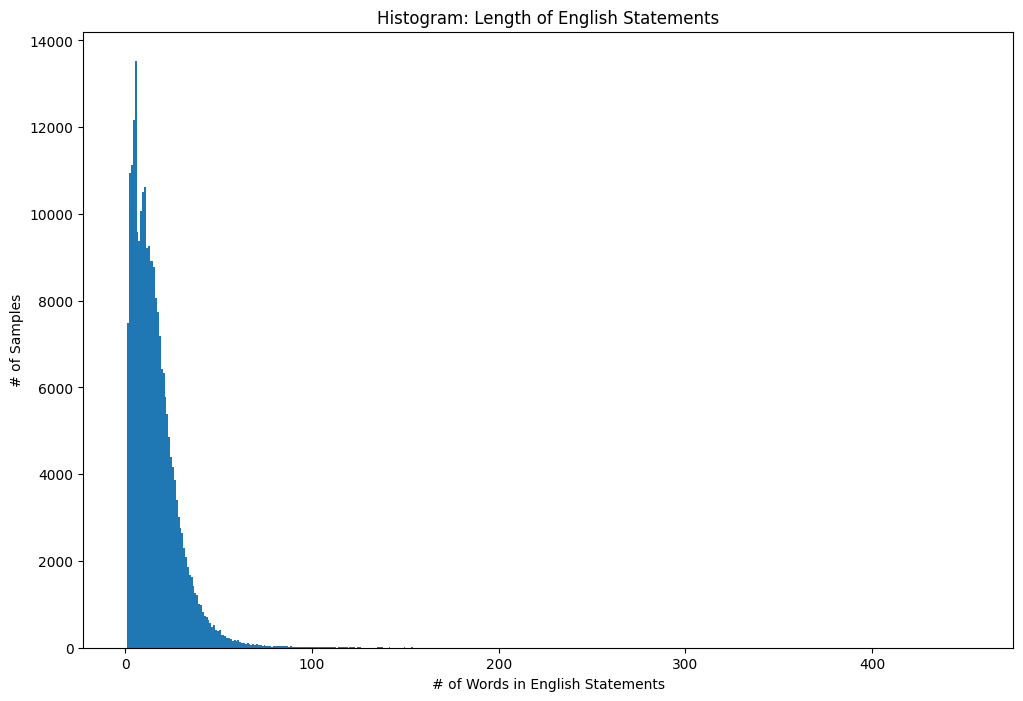

The Maximum length of English text is 452 words.


In [7]:
df['english_length'] = df['en'].str.split().str.len()

max_english_count = max(df['english_length'])

n_bin = max_english_count + 1
df.hist('english_length',
        grid=False,
        figsize=(12,8),
        range=(0,n_bin),
        bins=n_bin)
plt.title('Histogram: Length of English Statements')
plt.xlabel('# of Words in English Statements')
plt.ylabel("# of Samples")
plt.show()

print(f"The Maximum length of English text is {max_english_count} words.")

#### Visual: Length of German Entries

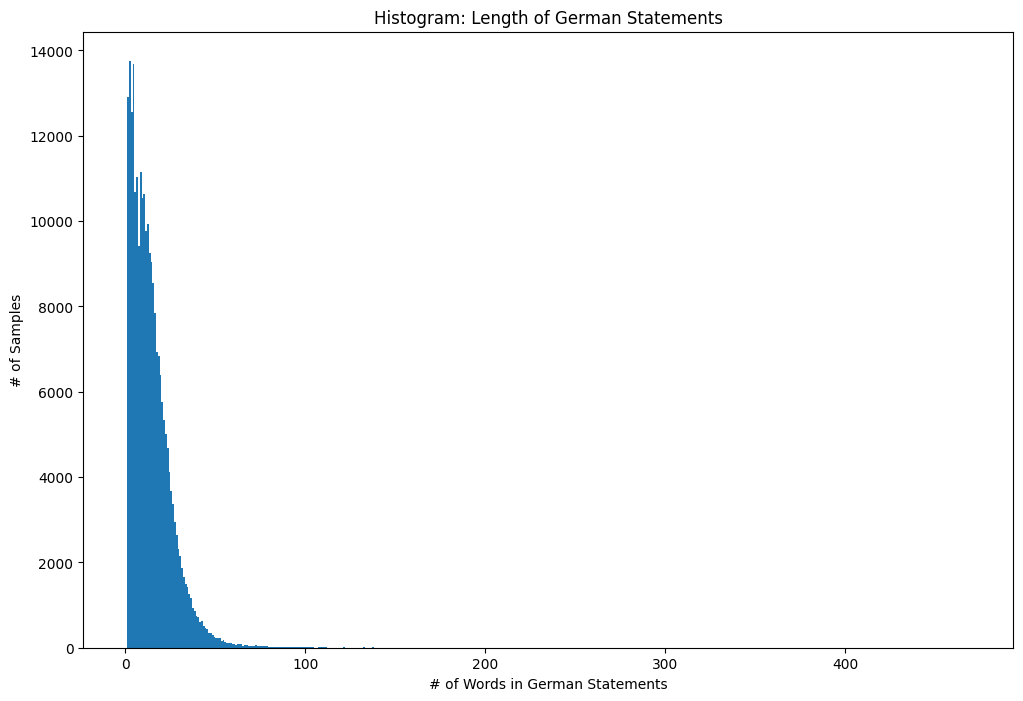

The Maximum length of German text is 469 words.


In [8]:
df['german_length'] = df['de'].str.split().str.len()

max_german_count = max(df['german_length'])

n_bin = max_german_count + 1
df.hist('german_length',
        grid=False,
        range=(0,n_bin),
        figsize=(12,8),
        bins=n_bin)
plt.title('Histogram: Length of German Statements')
plt.xlabel('# of Words in German Statements')
plt.ylabel("# of Samples")
plt.show()

print(f"The Maximum length of German text is {max_german_count} words.")

#### Trim Dataset Size & Drop Unnecessary Features

In [9]:
least_input_words = 3
most_input_words = 35

# make sure that German text is less than 35 & more than 3 words
df = df[df['german_length'] < most_input_words]
df = df[df['german_length'] > least_input_words]

# make sure that English text is less than 35 & more than 3 words
df = df[df['english_length'] < most_input_words]
df = df[df['english_length'] > least_input_words]

# reset the index
df = df.reset_index(drop=True)

# Remove columns that are no longer necessary
df = df.drop(columns=['german_length',
                      'english_length'
                      ]
             )

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188017 entries, 0 to 188016
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   de      188017 non-null  object
 1   en      188017 non-null  object
dtypes: object(2)
memory usage: 2.9+ MB


#### Final Preprocessing

In [10]:
all_data = df.to_dict(orient='records')
df = pd.Series(all_data)
df = pd.DataFrame(df)
df.rename(columns={ 0 : 'translation'}, inplace=True)
df.head()

,translation
0,{'de': 'Ein vorübergehender Anstieg der Körper...
1,{'de': 'Im Januar 2001 begann eine neue dreijä...
2,{'de': 'Während der ersten Woche beträgt die ü...
3,{'de': 'Eine Packung enthält eine bzw. vier Fe...
4,{'de': 'Sie dürfen ZYPREXA nach dem auf dem Um...


#### Convert to Dataset & Split into Train/Test/Eval Datasets

In [11]:
dataset = Dataset.from_pandas(df)

train_testEval = dataset.train_test_split(train_size=0.75)
test_eval = train_testEval['test'].train_test_split(train_size=0.50)

ds = DatasetDict({
    'train' : train_testEval['train'],
    'test' : test_eval['train'],
    'eval' : test_eval['test'],
})

print("Training Dataset Shape:", ds['train'].shape)
print("Testing Dataset Shape:", ds['test'].shape)
print("Evaluation Dataset Shape:", ds['eval'].shape)

print(f"\nTraining Dataset Example:\n{ds['train'][25]}")

Training Dataset Shape: (141012, 1)
Testing Dataset Shape: (23502, 1)
Evaluation Dataset Shape: (23503, 1)

Training Dataset Example:
{'translation': {'de': '8g 10 g 12 g 14 g 16 g 18 g 21 g 25 g', 'en': '12 g 14 g 16 g 18 g 21 g 25 g'}}


#### Basic Values/Constants

In [12]:
set_seed = 42
NUM_OF_EPOCHS = 5

BATCH_SIZE = 16
LEARNING_RATE = 2e-5

SOURCE_LANGUAGE = "de"
TARGET_LANGUAGE = "en"

MODEL_CKPT = "Helsinki-NLP/opus-mt-de-en"
MODEL_NAME = f"{MODEL_CKPT.split(f'/')[-1]}-OPUS_Medical_German_to_English"

REPORTS_TO = "tensorboard"
STRATEGY = "epoch"

#### Create Tokenizer

In [13]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


#### Create Preprocessing Function

In [14]:
def tokenizing_function(examples):
    inputs = [ex[SOURCE_LANGUAGE] for ex in examples['translation']]
    targets = [ex[TARGET_LANGUAGE] for ex in examples['translation']]
    model_inputs = tokenizer(inputs,
                             text_target=targets,
                             truncation=True)
    return model_inputs

#### Apply Preprocessing Function to Dataset

In [15]:
encoded_ds = ds.map(tokenizing_function,
                    batched=True)

print(encoded_ds['train'].shape)
print(encoded_ds['test'].shape)
print(encoded_ds['eval'].shape)

Map:   0%|          | 0/141012 [00:00<?, ? examples/s]

Map:   0%|          | 0/23502 [00:00<?, ? examples/s]

Map:   0%|          | 0/23503 [00:00<?, ? examples/s]

(141012, 4)
(23502, 4)
(23503, 4)


#### Instantiate Model

In [16]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_CKPT)

#### Instantiate Data Collator

In [17]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer,
                                       model=MODEL_CKPT)

#### Create Function to Compute Metrics

In [18]:
bleu_metric = evaluate.load("sacrebleu")
rouge_metric = evaluate.load("rouge")

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds,
                                           skip_special_tokens=True)

    labels = np.where(labels != -100,
                      labels,
                      tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels,
                                            skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds,
                                                     decoded_labels)

    bleu_results = bleu_metric.compute(predictions=decoded_preds,
                                       references=decoded_labels)
    rouge_results = rouge_metric.compute(predictions=decoded_preds,
                                         references=decoded_labels)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id)
                       for pred in preds]

    return {"bleu" : bleu_results["score"],
            "rouge" : rouge_results,
            "Prediction Lengths": prediction_lens}

#### Instantiate Training Arguments

In [19]:
args = Seq2SeqTrainingArguments(output_dir=MODEL_NAME,
                                auto_find_batch_size=True,
                                gradient_accumulation_steps=4,
                                eval_accumulation_steps=4,
                                evaluation_strategy="no",
                                save_strategy=STRATEGY,
                                logging_strategy="steps",
                                logging_steps=250,
                                logging_first_step=True,
                                learning_rate=LEARNING_RATE,
                                report_to=REPORTS_TO,
                                weight_decay=0.01,
                                disable_tqdm=False,
                                num_train_epochs=NUM_OF_EPOCHS,
                                predict_with_generate=True,
                                fp16=True,
                                group_by_length=True,
                                hub_private_repo=True,
                                push_to_hub=True
                                )

#### Instantiate Trainer

In [20]:
trainer = Seq2SeqTrainer(model=model,
                         args=args,
                         train_dataset=encoded_ds['train'],
                         eval_dataset=encoded_ds['eval'],
                         tokenizer=tokenizer,
                         data_collator=data_collator,
                         compute_metrics=compute_metrics)

Cloning https://huggingface.co/DunnBC22/opus-mt-de-en-OPUS_Medical_German_to_English into local empty directory.


#### Train Model

In [21]:
train_results = trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
1,1.087600
250,1.260200
500,1.192200
750,1.207600
1000,1.138000
1250,1.138400
1500,1.144300
1750,1.105600
2000,1.108400
2250,1.108500


Adding files tracked by Git LFS: ['source.spm', 'target.spm']. This may take a bit of time if the files are large.


#### Push Model to HuggingFace Hub (My Profile!)

In [22]:
trainer.push_to_hub()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/282M [00:00<?, ?B/s]

Upload file runs/Aug15_16-48-49_22b6108997f2/events.out.tfevents.1692118158.22b6108997f2.741.0:   0%|         …

To https://huggingface.co/DunnBC22/opus-mt-de-en-OPUS_Medical_German_to_English
   47fbb7a..8613c07  main -> main

   47fbb7a..8613c07  main -> main

To https://huggingface.co/DunnBC22/opus-mt-de-en-OPUS_Medical_German_to_English
   8613c07..9ce42bb  main -> main

   8613c07..9ce42bb  main -> main



'https://huggingface.co/DunnBC22/opus-mt-de-en-OPUS_Medical_German_to_English/commit/8613c07956fff8939d64bfde0855a2fed45b31a8'

#### Save & Log Model

In [23]:
trainer.save_model()
trainer.save_state()

#### Evaluate Model

In [ ]:
metrics = trainer.evaluate()

#### Print, Log, & Save Metric Values

In [29]:
print(metrics)

{'eval_loss': 0.8722850680351257, 'eval_bleu': 53.88195581001609, 'eval_rouge': {'rouge1': 0.7664036885530349, 'rouge2': 0.6283763158877561, 'rougeL': 0.7370112957604222, 'rougeLsum': 0.7370291617503089}, 'eval_Prediction Lengths': [23, 22, 7, 20, 14, 14, 13, 11, 45, 38, 34, 28, 29, 18, 13, 7, 16, 26, 22, 44, 33, 21, 28, 7, 11, 23, 22, 7, 17, 26, 15, 22, 25, 17, 30, 15, 21, 18, 23, 19, 20, 47, 29, 13, 10, 33, 24, 10, 14, 55, 19, 19, 18, 19, 15, 19, 21, 7, 21, 19, 19, 15, 22, 16, 13, 8, 16, 11, 23, 14, 12, 12, 22, 16, 7, 20, 31, 22, 16, 17, 7, 37, 19, 23, 29, 26, 27, 19, 18, 26, 36, 47, 14, 34, 31, 8, 20, 24, 18, 23, 7, 24, 14, 36, 20, 18, 29, 34, 22, 23, 13, 25, 5, 17, 55, 30, 29, 11, 14, 17, 20, 25, 27, 18, 16, 33, 32, 19, 23, 7, 23, 15, 23, 27, 24, 17, 6, 43, 10, 10, 23, 23, 12, 27, 9, 43, 12, 15, 8, 17, 30, 22, 12, 27, 36, 22, 11, 22, 14, 18, 28, 24, 39, 11, 12, 22, 22, 11, 26, 19, 13, 7, 13, 13, 12, 16, 27, 11, 10, 8, 28, 21, 42, 18, 31, 22, 19, 23, 22, 23, 28, 10, 17, 20, 28, 18, 

### Notes & Other Takeaways From This Project
****
- I am ecstatic about the results!
- Yes, I could have fine-tuned the model for longer, but given the inputs, I am pleased with the output!

****

#### Citations

- Model Checkpoint
    >

- Metrics
    - Bleu
        > @INPROCEEDINGS{Papineni02bleu:a, author = {Kishore Papineni and Salim Roukos and Todd Ward and Wei-jing Zhu}, title = {BLEU: a Method for Automatic Evaluation of Machine Translation}, booktitle = {}, year = {2002}, pages = {311--318}}
        
        > @inproceedings{lin-och-2004-orange, title = "{ORANGE}: a Method for Evaluating Automatic Evaluation Metrics for Machine Translation", author = "Lin, Chin-Yew and Och, Franz Josef", booktitle = "{COLING} 2004: Proceedings of the 20th International Conference on Computational Linguistics", month = "aug 23{--}aug 27", year = "2004", address = "Geneva, Switzerland", publisher = "COLING", url = "https://www.aclweb.org/anthology/C04-1072", pages = "501--507",}
    
    - Rouge
        > @inproceedings{lin-2004-rouge, title = '{ROUGE}: A Package for Automatic Evaluation of Summaries', author = 'Lin, Chin-Yew', booktitle = 'Text Summarization Branches Out', month = jul, year = '2004', address = 'Barcelona, Spain', publisher = 'Association for Computational Linguistics', url = 'https://www.aclweb.org/anthology/W04-1013', pages = '74--81',}